In [1]:
import copy
import itertools
import os
from typing import List
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
from pydantic import BaseModel, Field
from transformers import AutoTokenizer

In [2]:
from pydantic_settings import BaseSettings, SettingsConfigDict
class DBSettings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file=".env", env_file_encoding="utf-8", extra="ignore"
    )
    postgres_user: str
    postgres_password: str
    postgres_db: str
    postgres_port: str
    
class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../../.env", env_file_encoding="utf-8", extra="ignore"
    )
    data_dir: str

settings = Settings()
db_settings = DBSettings()
print(db_settings.postgres_db)

psi_king


# 1. Prepare Data
* AutoRAGRetrieval: 금융, 공공, 의료, 법률, 커머스 5개 분야에 대해, pdf를 파싱하여 구성한 한국어 문서 검색 데이터셋 (`yjoonjang/markers_bm`)
    * https://huggingface.co/datasets/yjoonjang/markers_bm

In [3]:
file_path = os.path.join(
    settings.data_dir, "retrieval_dataset/markers_bm/corpus/corpus-00000-of-00001.parquet"
)

df = pd.read_parquet(file_path)
print(df.shape, df.columns)

(720, 3) Index(['_id', 'text', 'title'], dtype='object')


In [4]:
print(df.iloc[0]['_id'])
print(df.iloc[0]['title'])
print(df.iloc[0]['text'])

commerce - B2BDigComm.pdf - 1

Adobe
디지털 커머스 시대,
B2B 비즈니스 생존 전략
B2B 비즈니스를 e커머스에 통합해야 하는
3가지 이유


Text(0.5, 1.0, 'yjoonjang/markers_bm - text length')

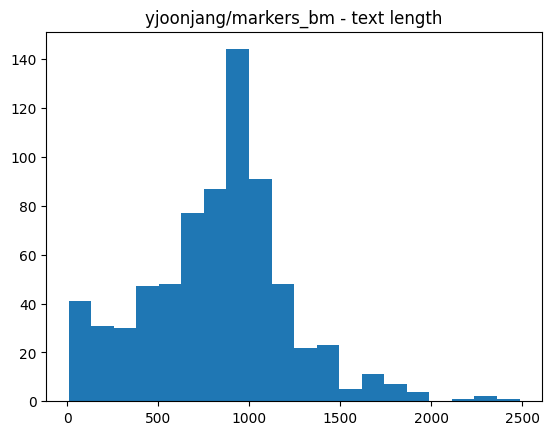

In [5]:
text_lens = [len(df.iloc[i]['text']) for i in range(df.shape[0])]
plt.hist(text_lens, bins = 20)
plt.title('yjoonjang/markers_bm - text length')

# 2. Init DB Collection

In [6]:
from llama_index.core import Settings
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.postgres import PGVectorStore

import numpy as np
import psycopg2
from sqlalchemy import make_url

In [7]:
## Silence errors
Settings.embed_model = None

Embeddings have been explicitly disabled. Using MockEmbedding.


In [8]:
connection_string = "postgresql://{}:{}@localhost:{}/{}".format(
    db_settings.postgres_user,
    db_settings.postgres_password,
    db_settings.postgres_port,
    db_settings.postgres_db
)

db_name = db_settings.postgres_db
print(f"DB: {db_name}")
conn = psycopg2.connect(connection_string)
conn.autocommit=True

## Initialize vector store instance
url = make_url(connection_string)

## hnsw indexing config
hnsw_config = {
    "hnsw_m": 16,
    "hnsw_ef_construction": 64,
    "hnsw_ef_search": 40,
    "hnsw_dist_method": "vector_cosine_ops",
}

DB: psi_king


## 2-1. text_search_config setting
* llama_index.vector_stores.postgres.PGVectorStore [link](https://github.com/run-llama/llama_index/blob/34184044a31d0f16bc7855b0ee2ed5ffc14829a8/llama-index-integrations/vector_stores/llama-index-vector-stores-postgres/llama_index/vector_stores/postgres/base.py#L122)
    * text_search_config: Text search configuration. Defaults to "english".

Usage of `text_search_config` param inside `PGVectorStore`
* `to_tsvector('korean', content)`
* https://taejoone.jeju.onl/posts/2024-01-27-postgres-16-korean/
```
text_search_tsv = Column(  # type: ignore
    TSVector(),
    Computed(
        "to_tsvector('%s', text)" % text_search_config, persisted=True
    ),
)
```

In [9]:
# https://github.com/run-llama/llama_index/blob/34184044a31d0f16bc7855b0ee2ed5ffc14829a8/llama-index-integrations/vector_stores/llama-index-vector-stores-postgres/llama_index/vector_stores/postgres/base.py#L122
# text_search_config: Text search configuration. Defaults to "english".
embedding_dim = 64

vector_store = PGVectorStore.from_params(
    database=db_name,
    host=url.host,
    password=url.password,
    port=url.port,
    user=url.username,
    table_name="markers_bm",
    embed_dim=embedding_dim,
    hnsw_kwargs=hnsw_config,
    text_search_config="korean",
    hybrid_search=True,
)

## create storage context
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [10]:
storage_index = VectorStoreIndex.from_vector_store(vector_store)

# 3. insert data

In [11]:
import json

from llama_index.core import Document
from llama_index.core.schema import TextNode
from llama_index.core.indices.utils import embed_nodes
from llama_index.core.ingestion.pipeline import run_transformations

In [17]:
## row -> TextNode (Document)
documents = []

for i in tqdm(range(df.shape[0])):
    row = df.iloc[i]
    embedding = np.random.normal(0, 1, embedding_dim)
    document = Document(
        text = row["text"],
        metadata = {
            "docid": str(row["_id"]),
            "title": str(row["title"]),
        },
        text_template='{content}',
        embedding = embedding.tolist()
    )
    documents.append(document)

100%|██████████| 720/720 [00:00<00:00, 36219.37it/s]


In [18]:
documents[:2]

[Document(id_='4d10f265-4aa5-4336-b476-a6c096d82450', embedding=[0.036047022655346844, 2.375358079225267, 0.320951309712542, -1.1186557367998347, -0.97701890875044, -0.4053277355107894, 0.2784389792923222, -0.42430654089852343, 0.14108908848701027, 0.4908356844860926, -1.4540173875056335, 0.48302658773977164, -0.46223459340227685, -1.0911283677242052, 0.23536714571307185, -0.17886571083963265, 1.294911846331463, 0.3553800759647416, -0.6708332228861729, -0.4113197729035693, -0.9737781301210773, -1.8341898621040196, -0.9063949259479329, -0.5704305878872992, 1.2199703150274592, 1.5563939031800356, 0.6002630125556857, -0.5626804081706769, -2.3219485538265383, 1.3917494760633038, 0.44331616469645174, 0.1944480004990625, 0.37928277644921715, 0.09854193316807505, 1.7224682081430789, 1.2886465874405633, -1.5061850518259232, -1.095137508958061, -0.5180322283281623, 0.9808385758353585, 0.8256717918537926, -0.07809388576156995, 1.4893714851644702, -0.6416035185942329, 0.5325179506271938, -0.53280

In [19]:
storage_index.insert_nodes(documents, show_progress=True)

Generating embeddings: 0it [00:00, ?it/s]

# 4. Test Retrieval

In [ ]:
retriever_args = {
    "similarity_top_k": 30,
    # "vector_store_query_mode": "hybrid"
    "vector_store_query_mode": "sparse" # test with sparse
}
retriever = storage_index.as_retriever(**retriever_args)

In [23]:
query = "시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차에 차이가 있는데 그 차이점은 무엇인가요?"
nodes = retriever.retrieve(query)

In [27]:
print(nodes[0].text)

금융위원회 보도자료 금융감독원
2024.1.31.(수) 금융위 호의후
보도시점 배포 2024.1.30.(화) 10:00
(별도공지)
지방은행의 시중은행 전환시
인가방식 및절차
은행법 제8조 은행업인가 규정에 따른 '인가내용의 변경'을 통해 전환
신규인가에 준하여 법령상 모든 세부심사요건 심사
예비인가 절차는 생략 가능하되, 신청인이 희망할 경우에는 진행
정부는 2023년 7월 5일 은행권 경쟁촉진을 위해 지방은행의 시중은행
전환을 추진하겠다고 발표 한 바 있습니다.
* 「은행권 경영·영업 관행·제도 개선 방안」
현행 은행업 인가체계상 은행업 영위를 위해서는 시중은행·지방은행·인터넷
전문은행 모두 은행법 제8조에 따라 금융위원회의 인가를 받아야 합니다.
시중은행·지방은행·인터넷전문은행은 인가요건·절차가 대부분 동일하나, 일부
인가요건' 및 영업구역·방식에서 차이가 존재합니다.
* 최소자본금: (시중) 1,000억원 (지방) 250억원 (인터넷) 250억원
비금융주력자 주식보유한도: (시중) 4% (지방) 15% (인터넷엾) 34%
<표> 영업구역 및 영업방식에 따른 은행의 종류 구분
영업방식 ＼영업구역 전국 일부 제한
온 + 오프라인 시중은행 지방은행
온라인 인터넷전문은행
다만, 현행 은행법령상 지방은행의 시중은행 전환에 관한 명시적인 규정은
없으며, 종전에도 은행 종류의 전환 사례는 없었습니다. 지방은행의 정관
에서 특정지역으로 제한하고 있는 영업구역을 전국으로 변경시 시중은행
으로 전환이 가능하다는 일부의견도 있으나, 은행 종류의 전환은 금융감독
정책의 중요사항으로 사전 승인절차 없이 정관 변경만으로 허용하는 것은
부적절한 측면이 있습니다.
-1-


In [36]:
print(type(nodes[0]))
for node in nodes[:5]:
    print(f"NODE {node.id_}")
    print(f"TEXT:\n{repr(node.text[:100])}")

<class 'llama_index.core.schema.NodeWithScore'>
NODE efa837dc-95ea-4042-b241-34646c060f1b
TEXT:
'금융위원회 보도자료 금융감독원\n2024.1.31.(수) 금융위 호의후\n보도시점 배포 2024.1.30.(화) 10:00\n(별도공지)\n지방은행의 시중은행 전환시\n인가방식 및절차\n은행'
NODE 7db25734-d601-44ab-9179-79fa2af89edc
TEXT:
'2. 심사 내용\n가. 쟁점 사항: 모든 세부심사요건 심사 VS 일부요건 심사\n□ 지방은행의 경우 과거 은행업 인가를 받고 계속 영업중\nO 지방은행과 시중은행에 요구되는 인가요건은 '
NODE 6c734284-b159-4c2b-bfae-783de2b35666
TEXT:
'참고 1 현행 은행업 인가체계\n□은행업 영위를 위해서는 「은행법」(제8조)상 금융위 인가 필요\n* (은행법 §81) 은행업을 경영하려는 자는 금융위원회의 인가를 받아야 한다.\no '
NODE 48c415a5-351c-4edb-a5f2-d704ffeed85c
TEXT:
'이에 금융위원회(사무처) 및 금융감독원은 현행 은행법령 체계에서 지방\n은행의 시중은행 전환 방식·절차 등을 명확히 하기 위해 「지방은행의 시중\n은행 전환시 인가방식 및 절차」 를 '
NODE 62951d09-fa05-4537-92d3-d722ce7212cd
TEXT:
'1. 법 제8조제2항 각 호의 요건을 충족하는지를 확인하기 위하여 다른 기관 등으\n로부터 필요한 자료를 제공받는 데에 걸리는 기간\n2. 제5항에 따라 인가신청서 흠결의 보완을 요구'


## 4-1. Metadata Filtering

In [38]:
print(nodes[0].metadata[''])

{'docid': 'finance - 240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf - 1', 'title': ''}


In [66]:
## Metadata Filtering
from llama_index.core.vector_stores.types import (
    MetadataFilter,
    MetadataFilters,
)
retriever_args = {
    "similarity_top_k": 10,
    "vector_store_query_mode": "sparse"
}

filters = MetadataFilters(
    filters = [
        MetadataFilter(
            key="docid", value="law", operator="text_match"
        ),
    ],
    condition="and",
)

retriever = storage_index.as_retriever(filters=filters, **retriever_args)

In [67]:
query = "시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차에 차이가 있는데 그 차이점은 무엇인가요?"
nodes = retriever.retrieve(query)
print(len(nodes))

10


In [69]:
for node in nodes[:5]:
    print(f"NODE {node.id_}")
    print(f"docid: {node.metadata['docid']}")

NODE 5b5999bb-9621-436d-b880-a5d62094b663
docid: law - 행정_조세_가상자산.pdf - 5
NODE 6e964bd8-fb50-4fb5-a93b-4f4c5d504468
docid: law - 민사_스마트폰.pdf - 18
NODE f9446463-73e0-4084-b06e-8e534bc6d16b
docid: law - 민사_미성년자인.pdf - 10
NODE e9591546-f446-40a8-af57-13cb6dbc9e76
docid: law - 민사_분양받은.pdf - 3
NODE a57d59b7-026f-4779-83b2-b69f5952e675
docid: law - 민사_스마트폰.pdf - 10
